In [1]:
# Cell #0 — Environment Setup & Data Verification

import pandas as pd
import numpy as np
import os
import sklearn
import matplotlib
import seaborn as sns
import nltk

print("✅ Environment setup successful!")
print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print(f"Seaborn: {sns.__version__}")
print(f"NLTK: {nltk.__version__}")

# Define dataset path
RAW_PATH = "../data/raw/all-data.csv"

# Check dataset existence
if os.path.exists(RAW_PATH):
    print("📁 Raw dataset found!")
else:
    print("❌ Dataset not found! Please place all-data.csv inside data/raw/")


✅ Environment setup successful!
Pandas: 2.3.3
NumPy: 2.3.4
Scikit-learn: 1.7.2
Matplotlib: 3.10.7
Seaborn: 0.13.2
NLTK: 3.9.2
📁 Raw dataset found!


In [2]:
# Cell #1 — Load & Inspect Dataset (with correct encoding)

import pandas as pd

RAW_PATH = "../data/raw/all-data.csv"

df = pd.read_csv(
    RAW_PATH,
    header=None,
    names=["sentiment", "sentence"],
    encoding="latin-1"
)

print("✅ Dataset loaded successfully!")
print(f"Shape: {df.shape}")

print("\n📊 Columns:")
print(df.columns.tolist())

display(df.head())

print("\n📘 Dataset Info:")
print("-" * 50)
df.info()

print("\n🔍 Sentiment Distribution (%):")
sent_dist = (df['sentiment'].value_counts(normalize=True) * 100).round(2)
display(sent_dist)


✅ Dataset loaded successfully!
Shape: (4846, 2)

📊 Columns:
['sentiment', 'sentence']


,sentiment,sentence
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...



📘 Dataset Info:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  4846 non-null   object
 1   sentence   4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB

🔍 Sentiment Distribution (%):


sentiment
neutral     59.41
positive    28.13
negative    12.46
Name: proportion, dtype: float64

In [3]:
# Cell #2 — Text Cleaning & Preprocessing

import re
import nltk
from nltk.corpus import stopwords

# Download stopwords if not available
nltk.download('stopwords', quiet=True)

STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove punctuation and special characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    
    # Remove numbers
    text = re.sub(r"\d+", "", text)
    
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    
    # Remove stopwords
    text = " ".join(word for word in text.split() if word not in STOPWORDS)
    
    return text

# Apply cleaning
df['clean_sentence'] = df['sentence'].apply(clean_text)

print("🧹 Text cleaning completed!")
display(df[['sentence', 'clean_sentence']].head(10))


🧹 Text cleaning completed!


,sentence,clean_sentence
0,"According to Gran , the company has no plans t...",according gran company plans move production r...
1,Technopolis plans to develop in stages an area...,technopolis plans develop stages area less squ...
2,The international electronic industry company ...,international electronic industry company elco...
3,With the new production plant the company woul...,new production plant company would increase ca...
4,According to the company 's updated strategy f...,according company updated strategy years baswa...
5,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,financing aspocomp growth aspocomp aggressivel...
6,"For the last quarter of 2010 , Componenta 's n...",last quarter componenta net sales doubled eurm...
7,"In the third quarter of 2010 , net sales incre...",third quarter net sales increased eur mn opera...
8,Operating profit rose to EUR 13.1 mn from EUR ...,operating profit rose eur mn eur mn correspond...
9,"Operating profit totalled EUR 21.1 mn , up fro...",operating profit totalled eur mn eur mn repres...


In [4]:
# Cell #3 — TF-IDF Vectorization

from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,   # top 5k words
    ngram_range=(1,2),   # unigrams + bigrams
    stop_words='english' # remove english stopwords
)

# Fit-transform clean text
X = tfidf.fit_transform(df['clean_sentence'])

print("✅ TF-IDF vectorization completed!")
print("Vectorized shape:", X.shape)

# Encode sentiment labels (positive, neutral, negative)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['sentiment'])

print("Encoded labels:", list(label_encoder.classes_))


✅ TF-IDF vectorization completed!
Vectorized shape: (4846, 5000)
Encoded labels: ['negative', 'neutral', 'positive']


Train shape: (3876, 5000)
Test shape: (970, 5000)

📈 Logistic Regression Accuracy: 72.68%

              precision    recall  f1-score   support

    negative       0.75      0.36      0.48       121
     neutral       0.73      0.93      0.82       576
    positive       0.70      0.47      0.56       273

    accuracy                           0.73       970
   macro avg       0.73      0.58      0.62       970
weighted avg       0.72      0.73      0.70       970



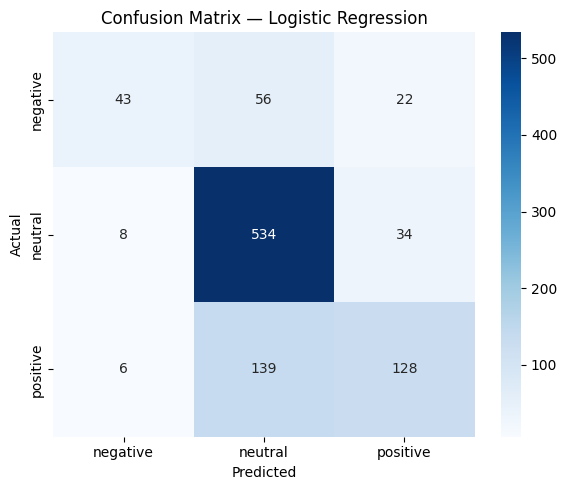

✅ Saved confusion matrix to: ../assets/visuals/confusion_matrix_logreg.png


In [5]:
# Cell #4 — Train/Test Split + Logistic Regression

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # keep class balance
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train, y_train)

# Predict
y_pred = log_reg.predict(X_test)

# Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"\n📈 Logistic Regression Accuracy: {acc*100:.2f}%\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()

# Save plot
os.makedirs("../assets/visuals", exist_ok=True)
save_path = "../assets/visuals/confusion_matrix_logreg.png"
plt.savefig(save_path, dpi=300)
plt.show()

print(f"✅ Saved confusion matrix to: {save_path}")



📈 SVM Accuracy: 74.54%

              precision    recall  f1-score   support

    negative       0.66      0.53      0.59       121
     neutral       0.78      0.86      0.82       576
    positive       0.68      0.60      0.64       273

    accuracy                           0.75       970
   macro avg       0.71      0.66      0.68       970
weighted avg       0.74      0.75      0.74       970



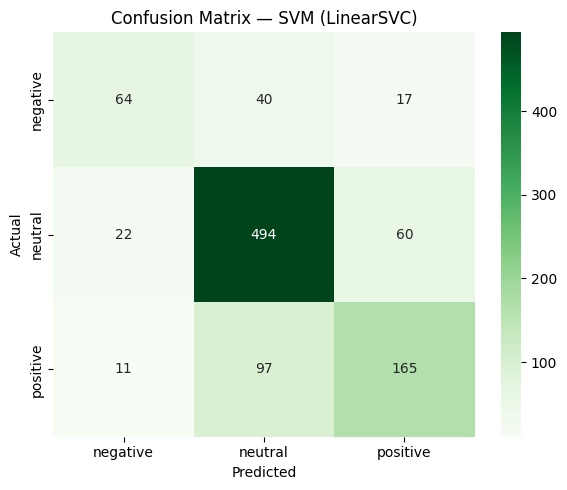

✅ Saved confusion matrix to: ../assets/visuals/confusion_matrix_svm.png


In [6]:
# Cell #5 — Linear SVM (SVC)

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Train SVM
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

# Predict
y_pred_svm = svm_model.predict(X_test)

# Evaluate
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"\n📈 SVM Accuracy: {acc_svm*100:.2f}%\n")
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm_svm, annot=True, fmt="d", cmap="Greens",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title("Confusion Matrix — SVM (LinearSVC)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()

# Save
os.makedirs("../assets/visuals", exist_ok=True)
save_path_svm = "../assets/visuals/confusion_matrix_svm.png"
plt.savefig(save_path_svm, dpi=300)
plt.show()

print(f"✅ Saved confusion matrix to: {save_path_svm}")


In [7]:
# Cell #6 — Save Best Model + TF-IDF Vectorizer + LabelEncoder

import joblib
import os

os.makedirs("../models", exist_ok=True)

model_path = "../models/svm_sentiment_model.pkl"
vectorizer_path = "../models/tfidf_vectorizer.pkl"
encoder_path = "../models/label_encoder.pkl"

joblib.dump(svm_model, model_path)
joblib.dump(tfidf, vectorizer_path)
joblib.dump(label_encoder, encoder_path)

print("✅ Model, vectorizer, and label encoder saved!")
print(model_path)
print(vectorizer_path)
print(encoder_path)


✅ Model, vectorizer, and label encoder saved!
../models/svm_sentiment_model.pkl
../models/tfidf_vectorizer.pkl
../models/label_encoder.pkl
